# Summer temperature change relative to IPCC 1986-2005 baseline
#### Notes

Summer:

Northern Hemisphere JJA: June, July, August

Southern Hemisphere DJF: December, January, February



In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
from datetime import date

import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from scipy import stats
from tqdm import tnrange, tqdm_notebook

# import util
# import population_tools

from config import (DATA_SRC, WEATHER_SRC, POP_DATA_SRC)

In [3]:
plt.rcParams['figure.dpi'] = 72
plt.rcParams['savefig.dpi'] = 72

In [4]:
MAX_YEAR = 2019

In [5]:
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

ERA_MONTHLY_FOLDER = WEATHER_SRC / 'era5' / 'monthly_means_0.5'
CLIMATOLOGY_FILE_MONTHLY = WEATHER_SRC / 'era5' / 'era_climatology_monthly_0.5.nc'


# Load weather

In [6]:
temperature_monthly = xr.open_mfdataset(sorted(ERA_MONTHLY_FOLDER.glob('*.grib')), engine='cfgrib', combine='nested', concat_dim='time').t2m

In [7]:
climatology = xr.open_dataset(CLIMATOLOGY_FILE_MONTHLY).t2m

## Get ∆T for each month of each year relative to the ERA climatology monthly means file


In [8]:
def sub_months(era_t_yr):
    #Swap in the time axis so the datasets auto-align
    tmp = climatology.copy().rename({'month':'time'})
    tmp['time'] = era_t_yr.time
    return era_t_yr - tmp
    
delta_t = temperature_monthly.groupby('time.year').apply(sub_months)

## Get the mean delta for each summer

In [9]:
def collect_summer_delta(delta_t):
    """Split the word data into north and south, 
    keep only the summer months for each, then re-join them
    """
    # Wrap in a function to clear temporary vars from memory
    
    lat_north = delta_t.latitude[delta_t.latitude >= 0]    
    lat_south = delta_t.latitude[delta_t.latitude < 0]

    # Summer North
    summer_jja = delta_t['time.season'] == 'JJA'

    # Summer South
    summer_djf = delta_t['time.season'] == 'DJF'

    nh = delta_t.sel(time=summer_jja, latitude=lat_north).groupby('time.year').mean(dim='time')
    sh = delta_t.sel(time=summer_djf,latitude=lat_south).groupby('time.year').mean(dim='time')
    
    return xr.concat([nh, sh], dim='latitude')

summer_anom = collect_summer_delta(delta_t)

In [10]:
# Clean up the dataset coords a bit
summer_anom = summer_anom.drop(['surface','step', 'number'])

In [13]:
mask = xr.open_dataarray(DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc')
mask = (mask > 0) & (mask < 999)

### Export some example grids

In [41]:
summer_anom.sel(year=2018, drop=True).to_dataset(name='summer_warming').to_netcdf('summer_warming_2018.nc')

In [78]:
summer_anom.sel(year=2018, drop=True).where(mask).to_dataset(name='summer_warming').to_netcdf('summer_warming_masked_2018.nc')

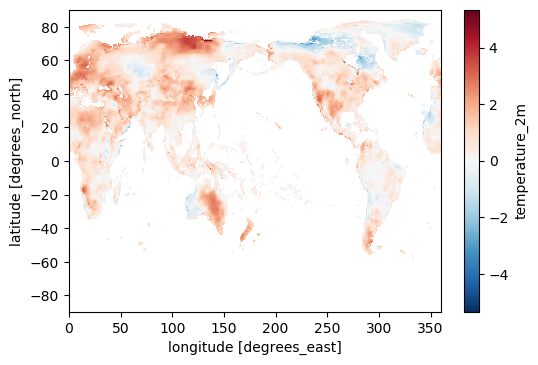

In [56]:
data = summer_anom.sel(year=2018, drop=True).where(mask)
data.plot()

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
import matplotlib.path
import matplotlib.ticker
from matplotlib.transforms import BboxTransform, Bbox
import numpy as np


# When drawing the flag, we can either use white filled land, or be a little
# more fancy and use the Natural Earth shaded relief imagery.
filled_land = True


def olive_path():
    """
    Return a Matplotlib path representing a single olive branch from the
    UN Flag. The path coordinates were extracted from the SVG at
    https://commons.wikimedia.org/wiki/File:Flag_of_the_United_Nations.svg.

    """
    olives_verts = np.array(
        [[0,   2,   6,   9,  30,  55,  79,  94, 104, 117, 134, 157, 177,
          188, 199, 207, 191, 167, 149, 129, 109,  87,  53,  22,   0, 663,
          245, 223, 187, 158, 154, 150, 146, 149, 154, 158, 181, 184, 197,
          181, 167, 153, 142, 129, 116, 119, 123, 127, 151, 178, 203, 220,
          237, 245, 663, 280, 267, 232, 209, 205, 201, 196, 196, 201, 207,
          211, 224, 219, 230, 220, 212, 207, 198, 195, 176, 197, 220, 239,
          259, 277, 280, 663, 295, 293, 264, 250, 247, 244, 240, 240, 243,
          244, 249, 251, 250, 248, 242, 245, 233, 236, 230, 228, 224, 222,
          234, 249, 262, 275, 285, 291, 295, 296, 295, 663, 294, 293, 292,
          289, 294, 277, 271, 269, 268, 265, 264, 264, 264, 272, 260, 248,
          245, 243, 242, 240, 243, 245, 247, 252, 256, 259, 258, 257, 258,
          267, 285, 290, 294, 297, 294, 663, 285, 285, 277, 266, 265, 265,
          265, 277, 266, 268, 269, 269, 269, 268, 268, 267, 267, 264, 248,
          235, 232, 229, 228, 229, 232, 236, 246, 266, 269, 271, 285, 285,
          663, 252, 245, 238, 230, 246, 245, 250, 252, 255, 256, 256, 253,
          249, 242, 231, 214, 208, 208, 227, 244, 252, 258, 262, 262, 261,
          262, 264, 265, 252, 663, 185, 197, 206, 215, 223, 233, 242, 237,
          237, 230, 220, 202, 185, 663],
         [8,   5,   3,   0,  22,  46,  46,  46,  35,  27,  16,  10,  18,
          22,  28,  38,  27,  26,  33,  41,  52,  52,  52,  30,   8, 595,
          77,  52,  61,  54,  53,  52,  53,  55,  55,  57,  65,  90, 106,
          96,  81,  68,  58,  54,  51,  50,  51,  50,  44,  34,  43,  48,
          61,  77, 595, 135, 104, 102,  83,  79,  76,  74,  74,  79,  84,
          90, 109, 135, 156, 145, 133, 121, 100,  77,  62,  69,  67,  80,
          92, 113, 135, 595, 198, 171, 156, 134, 129, 124, 120, 123, 126,
          129, 138, 149, 161, 175, 188, 202, 177, 144, 116, 110, 105,  99,
          108, 116, 126, 136, 147, 162, 173, 186, 198, 595, 249, 255, 261,
          267, 241, 222, 200, 192, 183, 175, 175, 175, 175, 199, 221, 240,
          245, 250, 256, 245, 233, 222, 207, 194, 180, 172, 162, 153, 154,
          171, 184, 202, 216, 233, 249, 595, 276, 296, 312, 327, 327, 327,
          327, 308, 284, 262, 240, 240, 239, 239, 242, 244, 247, 265, 277,
          290, 293, 296, 300, 291, 282, 274, 253, 236, 213, 235, 252, 276,
          595, 342, 349, 355, 357, 346, 326, 309, 303, 297, 291, 290, 297,
          304, 310, 321, 327, 343, 321, 305, 292, 286, 278, 270, 276, 281,
          287, 306, 328, 342, 595, 379, 369, 355, 343, 333, 326, 318, 328,
          340, 349, 366, 373, 379, 595]]).T
    olives_codes = np.array([1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 4, 4, 4, 4, 4, 4, 4, 4, 79, 1, 4, 4, 4, 4, 4,
                             4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 4, 4, 4, 4, 4, 79, 1, 4, 4, 4, 4, 4, 4, 2, 4,
                             4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 79, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 79, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4,
                             4, 4, 4, 4, 4, 79, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 4, 4, 4, 4, 4, 79, 1, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 4, 4, 4, 79, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 4, 79], dtype=np.uint8)

    return matplotlib.path.Path(olives_verts, olives_codes)


def plot_un_logo(year):
    blue = '#4b92db'

    # We're drawing a flag with a 3:5 aspect ratio.
    fig = plt.figure(figsize=[7, 4.5], facecolor=blue)
    # Put a blue background on the figure.
    blue_background = PathPatch(matplotlib.path.Path.unit_rectangle(),
                                transform=fig.transFigure, color=blue,
                                zorder=-1)
    fig.patches.append(blue_background)

    # Set up the Azimuthal Equidistant and Plate Carree projections
    # for later use.
    az_eq = ccrs.AzimuthalEquidistant(central_latitude=90)
    pc = ccrs.PlateCarree()

    # Pick a suitable location for the map (which is in an Azimuthal
    # Equidistant projection).
    ax = fig.add_axes([0.25, 0.24, 0.5, 0.54], projection=az_eq)

    # The background patch and outline patch are not needed in this example.
    ax.background_patch.set_facecolor('none')
    ax.outline_patch.set_edgecolor('none')

    # We want the map to go down to -60 degrees latitude.
    ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())

    # Importantly, we want the axes to be circular at the -60 latitude
    # rather than cartopy's default behaviour of zooming in and becoming
    # square.
    _, patch_radius = az_eq.transform_point(0, -60, pc)
    circular_path = matplotlib.path.Path.circle(0, patch_radius)
    ax.set_boundary(circular_path)

    gl = ax.gridlines(crs=pc, linewidth=1, color='white', linestyle='-')
    # Meridians every 45 degrees, and 5 parallels.
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(0, 361, 45))
    parallels = np.linspace(-60, 70, 5, endpoint=True)
    gl.ylocator = matplotlib.ticker.FixedLocator(parallels)

    data = summer_anom.sel(year=year, drop=True).where(mask)
    data.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                         cmap='RdBu_r',
                         add_colorbar=False,
                         vmin=-3, vmax=3
                               )
    ax.coastlines(color='lightgrey', linewidth=0.5)
    
    # Now add the olive branches around the axes. We do this in normalised
    # figure coordinates
    olive_leaf = olive_path()

    olives_bbox = Bbox.null()
    olives_bbox.update_from_path(olive_leaf)

    # The first olive branch goes from left to right.
    olive1_axes_bbox = Bbox([[0.47, 0.15], [0.725, 0.75]])
    olive1_trans = BboxTransform(olives_bbox, olive1_axes_bbox)

    # THe second olive branch goes from right to left (mirroring the first).
    olive2_axes_bbox = Bbox([[0.53, 0.15], [0.275, 0.75]])
    olive2_trans = BboxTransform(olives_bbox, olive2_axes_bbox)

    olive1 = PathPatch(olive_leaf, facecolor='white', edgecolor='none',
                       transform=olive1_trans + fig.transFigure)
    olive2 = PathPatch(olive_leaf, facecolor='white', edgecolor='none',
                       transform=olive2_trans + fig.transFigure)

    fig.patches.append(olive1)
    fig.patches.append(olive2)
    
    
    plt.text(-15, -30, '2019', transform=olive1_trans + fig.transFigure, color='white',
             fontsize=15, fontweight='bold'
            )
    
    return fig

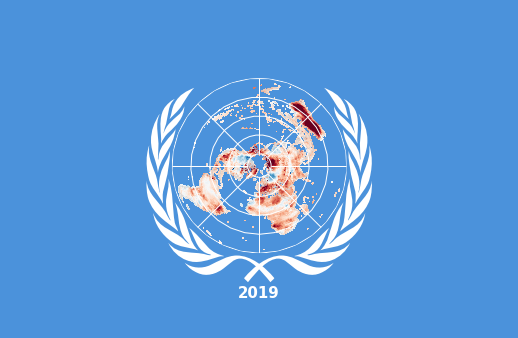

In [14]:
f = plot_un_logo(2019)
f.savefig('UN Warming.png')

In [15]:
from matplotlib.animation import FuncAnimation

In [16]:
def anim_un_logo(year):
    ax = fig.axes[0]
    ax.cla()
    # The background patch and outline patch are not needed in this example.
    ax.background_patch.set_facecolor('none')
    ax.outline_patch.set_edgecolor('none')

    # We want the map to go down to -60 degrees latitude.
    ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())

    # Importantly, we want the axes to be circular at the -60 latitude
    # rather than cartopy's default behaviour of zooming in and becoming
    # square.
    _, patch_radius = az_eq.transform_point(0, -60, pc)
    circular_path = matplotlib.path.Path.circle(0, patch_radius)
    ax.set_boundary(circular_path)

    gl = ax.gridlines(crs=pc, linewidth=1, color='white', linestyle='-')
    # Meridians every 45 degrees, and 5 parallels.
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(0, 361, 45))
    parallels = np.linspace(-60, 70, 5, endpoint=True)
    gl.ylocator = matplotlib.ticker.FixedLocator(parallels)

    data = summer_anom.sel(year=year, drop=True).where(mask)
    data.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                         cmap='RdBu_r',
                         add_colorbar=False,
                         vmin=-3, vmax=3
                               )
    ax.coastlines(color='lightgrey', linewidth=0.5)
    

    ax.text(-15, -30, f'{year}', transform=olive1_trans + fig.transFigure, color='white',
             fontsize=15, fontweight='bold'
            )


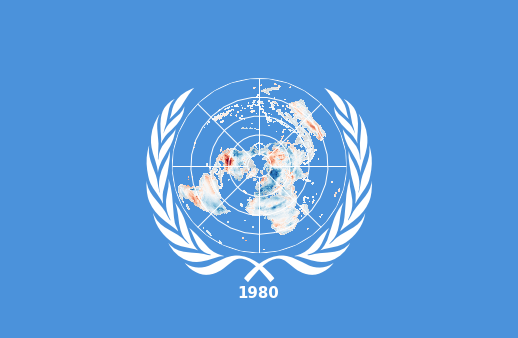

In [21]:
blue = '#4b92db'
# We're drawing a flag with a 3:5 aspect ratio.
fig = plt.figure(figsize=[7, 4.5], facecolor=blue)
# Put a blue background on the figure.
blue_background = PathPatch(matplotlib.path.Path.unit_rectangle(),
                            transform=fig.transFigure, color=blue,
                            zorder=-1)
fig.patches.append(blue_background)

# Set up the Azimuthal Equidistant and Plate Carree projections
# for later use.
az_eq = ccrs.AzimuthalEquidistant(central_latitude=90)
pc = ccrs.PlateCarree()

# Pick a suitable location for the map (which is in an Azimuthal
# Equidistant projection).
ax = fig.add_axes([0.25, 0.24, 0.5, 0.54], projection=az_eq)



# Now add the olive branches around the axes. We do this in normalised
# figure coordinates
olive_leaf = olive_path()

olives_bbox = Bbox.null()
olives_bbox.update_from_path(olive_leaf)

# The first olive branch goes from left to right.
olive1_axes_bbox = Bbox([[0.47, 0.15], [0.725, 0.75]])
olive1_trans = BboxTransform(olives_bbox, olive1_axes_bbox)

# THe second olive branch goes from right to left (mirroring the first).
olive2_axes_bbox = Bbox([[0.53, 0.15], [0.275, 0.75]])
olive2_trans = BboxTransform(olives_bbox, olive2_axes_bbox)

olive1 = PathPatch(olive_leaf, facecolor='white', edgecolor='none',
                   transform=olive1_trans + fig.transFigure)
olive2 = PathPatch(olive_leaf, facecolor='white', edgecolor='none',
                   transform=olive2_trans + fig.transFigure)

fig.patches.append(olive1)
fig.patches.append(olive2)

anim = FuncAnimation(fig, anim_un_logo, frames=range(1980, 2020), interval=250, repeat=False, repeat_delay=5000);

In [19]:
from IPython.display import HTML

In [20]:
HTML(anim.to_html5_video())

In [130]:
anim.save('un_logo_summer_anom.gif', writer = 'imagemagick') 